<title>
    # A model for binary multivariate time series


<h1 align=center> A model for binary multivariate time series generation </center>

In [3]:
import numpy as np
import pandas as pd
from IPython.display import display, HTML, Image
from scipy.stats import ttest_ind_from_stats, spearmanr
from sklearn.preprocessing import StandardScaler
import scipy
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import xlsxwriter 
import tqdm
import math
import xarray as xr
from scipy.special import softmax
%matplotlib inline


## Model definition

In [468]:
class binaryts:
    
    def __init__(self,d=10, A=None, B=None, sigma=None,R=10000):
        
        """
        Instanciates the binaryTS model. 
        
        Arguments: 
        
        - d: dimension of the model. 
        - A: (d,d) matrix that controls the dynamics related to the observed state. 
        - B: (d,d) matrix that controls the dynamics related to the latent state. 
        - sigma: (d,d) positive definite matrix that controls the variance of the noise. 
        - R: number of MCMC samples for expectation approximations used in VEM. 
        
        By default, the BinaryTS model is instanciated with random matrices A, B and sigma. You can provide your 
        own, but B should have all its eigenvalues of module less than 1 in order to enforce stability of the model
        (see companion paper for further information). 
        
        """
        
        self.d = d
        
        if A is None:
            self.A = 0.2*np.identity(d) + 0.1*np.random.randn(d,d)
        else: 
            self.A = A
            
        if B is None:     
            random_eig = np.random.uniform(low=-0.99,high=0.99,size=d) 
            self.B = np.diag(random_eig) 
        else:
            self.B = B

        self.eig_B = np.abs((np.linalg.eig(self.B)[0]))
        
        random_matrix = np.random.randn(d,d)
        self.sigma = 3*np.dot(random_matrix,random_matrix.T)
        self.sigma_inv = np.linalg.inv(self.sigma)
        self.data = None
        self.R = 1000
        
        
    ### Util functions###
    
    def sample(self,N=100,T=100,fixdata=True):
        
        """
        Samples N samles over T timesteps from the DGP. If fixdata is set to True, sampled x data is saved in 
        an attribute called self.data, along with (N,T) used for sampling in self.N and self.T. 
        """
        
        x_data = np.zeros((N,self.d,T))
        z_data = np.zeros((N,self.d,T))
        p_data = np.zeros((N,self.d,T))
        
        self.x0 = np.random.randint(0,2,size=(self.d,N))
        self.z0 = np.random.randn(self.d,N)
        
        x = self.x0
        z = self.z0
        
        x_data[:,:,0] = self.x0.T
        z_data[:,:,0] = self.z0.T
        p_data[:,:,0] = 1/2*np.ones((N,self.d))
        
        for t in np.arange(1,T): 
            z = self.A@x + self.B@z + np.random.multivariate_normal(mean=np.zeros(self.d),cov=self.sigma,size=N).T
            p = softmax(z,axis=0)
            x = np.random.binomial(1,p,size=(self.d,N))
            x_data[:,:,t] = x.T
            z_data[:,:,t] = z.T
            p_data[:,:,t] = p.T
            
        if fixdata: 
            self.data = x_data
            self.N = N
            self.T = T
        
        return x_data,z_data,p_data
    
    def snapshot(self,N,T,x_data=None,z_data=None,p_data=None,pltdim = 3,plttime=500,save=False): 
        
        """
        Generates and plots some data from the data generating process. This method displayes three components 
        of the DGP for every dimension: 
        - the observed, 0-1 valued process
        - the latent state
        - the probability associated to the current latent state obtained through softmaxification. 
        
        Arguments:
        
        - N: number of individuals (for plotting, one is choosen at random).
        - T: number of timesteps over which data is generated. 
        - x_data, z_data, p_data: allows to pass previously generate data for plotting (instead of 
        generating new observations).
        - pltdim: number of dimensions plotted. 
        - plttime: number of timesteps plotted. 
        - save: if set to True, a .pdf of the generated image is saved. 
        """
        
        if x_data is None and z_data is None and p_data is None: 
            x_data,z_data,p_data = self.sample(N=N,T=T,fixdata=False)
            
        plttime = np.minimum(T,plttime)
        pltdim = np.minimum(pltdim,self.d)
        random_ind = np.random.randint(0,N)
        
        sns.set_context('talk')
        sns.set_style('white')
            
        f,ax=plt.subplots(pltdim,3,figsize=(pltdim*25,pltdim*10))
        
        for i in np.arange(pltdim):
        
            ax[i,0].plot(x_data[random_ind,i,:plttime],c='orange')
            ax[i,1].plot(z_data[random_ind,i,:plttime],c='red')
            ax[i,2].plot(p_data[random_ind,i,:plttime],c='green')
                        
            ax[i,0].set_yticks([0,1])
            
            for a in ['left','bottom']:
            
                ax[i,0].spines[a].set_linewidth(2.5)
                ax[i,1].spines[a].set_linewidth(2.5)
                ax[i,2].spines[a].set_linewidth(2.5)
            
            for j in [0,1,2]:
                ax[i,j].spines["right"].set_visible(False)
                ax[i,j].spines["top"].set_visible(False)
        
        
        plt.tight_layout()
        
        if save: 
            
            plt.savefig('snapshot.pdf')
    
    
    ### Functions for VEM ###
    
    def check_data(self):
        
        if self.data is None: 
            raise ValueError('self.data is empty. Use self.sample(args,fixdata=True) to sample some data first.')
            
    def full_log_expectation(self,var): 
    
        """
        Approximates the expectation w.r.t. to the variational density of log sum_{all terms} exp in the ELBO term. 
        Handles overflow problems through max regularization. 
        Returns a scalar. 

        """
        
        T = self.T
        N = self.N
        d = self.d
        R = self.R

        mu = var[0:d]
        sigmas = var[d:]

        draw = np.random.randn(d,self.R)
        transformed_draw = draw*(np.tile(sigmas,(R,1)).T) + np.tile(mu,(R,1)).T
        max_draw = np.max(transformed_draw)
        transformed_draw += -max_draw
        approx = np.exp(transformed_draw)
        approx = approx.sum(axis=0)
        log_approx = np.log(approx)
        log_approx = log_approx.mean()

        return log_approx + max_draw
    
    def partial_log_expectation(self,var):
    
        """
        Approximates the expectation w.r.t. to the variational density of the log sum_{all but i} exp terms 
        in the ELBO term. 
        Returns a  (d,) array whose i-th term corresponds to the expectation of log sum_{all but i} exp.

        """
        
        T = self.T
        N = self.N
        d = self.d
        R = self.R

        mu = var[0:d]
        sigmas = var[d:]

        draw = np.random.randn(d,d-1,self.R)
        partial_log_sum = np.zeros(d)

        for i in np.arange(d):
            mask = [k for k in np.arange(d) if k != i]
            transformed_draw = draw[i,:,:]*(np.tile(sigmas[mask],(R,1)).T) + np.tile(mu[mask],(R,1)).T
            max_draw = np.max(transformed_draw)
            transformed_draw += -max_draw
            approx = np.exp(transformed_draw)
            approx = approx.sum(axis=0)
            log_approx = np.log(approx)
            log_approx = log_approx.mean()
            partial_log_sum[i] = log_approx + max_draw

        return partial_log_sum
    
    def compute_elbo(self,var=None,A=None,B=None,sigma=None):
        
        """
        Returns the Evidence Lower Bound (ELBO) of the model, normalized by 1/(N*T).  
        
        Arguments:
        - var: (2*d,) array of variational parameters. Should be provided as var=[mu,sigma], 
        where mu=[mu_1,...,mu_d] and sigma = [sigma_1,...,sigma_d]. 
        - A: (d,d) matrix for ELBO evaluation. If None, the true A matrix of the model is used. 
        - B: (d,d) matrix for ELBO evaluation. If None, the true A matrix of the model is used.
        - sigma: (d,d) positive definite matrix for ELBO evaluation. 
        If None, the true A matrix of the model is used.
        
        """
        
        self.check_data()
        
        T = self.T
        N = self.N
        d = self.d
        R = self.R
        
        if B is None: 
            B = self.B
        
        if A is None:
            A = self.A
            
        if sigma is None: 
            sigma = self.sigma
        
        data = self.data
        
        sigma_inv = self.sigma_inv
        
        mu = var[0:d]
        sigmas = var[d:]

        entropy_term = -(T*N/2)*(d*np.log(2*math.pi)+d*np.log(2*math.pi*math.e)+np.linalg.slogdet(sigma)[1]+2*np.log(sigmas).sum())

        full_log_approx = self.full_log_expectation(var)
        partial_log_approx = (self.partial_log_expectation(var)).reshape(d,)
        mu_partial_log = np.tile(mu - partial_log_approx,(T,1)).T
        pre_sum_data = np.multiply(self.data,mu_partial_log)
        expectation_term = pre_sum_data.sum() - d*T*N*full_log_approx + T*N*(partial_log_approx.sum())

        bilinear_term = -(T*N/2)*mu.T@(sigma_inv - 2*sigma_inv@B + B.T@sigma_inv@B)@mu

        norm_term = -1/2*(np.matmul(A,data[:,:,:-1]).sum(axis=(2,0))).T@sigma_inv@(np.matmul(A,data[:,:,:-1]).sum(axis=(2,0)))

        time_sum = (-(np.matmul(A,data[:,:,:-1]).sum(axis=(2,0)).T)@sigma_inv@(B-np.identity(d)))@mu

        diag_term = -T*N/2*(np.diag(sigma_inv+B.T@sigma_inv@B)*(sigmas**2)).sum()

        elbo_value = float((entropy_term + expectation_term + diag_term + time_sum + norm_term))

        return (1/N*T)*elbo_value
    
    ### Mu grad functions###
    
    def approx_mu_grad(self,var=None,A=None,B=None,sigma=None): 
        """
        Computes the full sum term in the mu gradient of the ELBO via MCMC approximation.
        """

        self.check_data()
        
        T = self.T
        N = self.N
        d = self.d
        R = self.R
        
        if B is None: 
            B = self.B
        
        if A is None:
            A = self.A
            
        if sigma is None: 
            sigma = self.sigma
        
        data = self.data
        
        sigma_inv = self.sigma_inv
        
        mu = var[0:d]
        sigmas = var[d:]

        x_sum = data.sum(axis=(0,2))

        draw = np.random.randn(d,R)
        transformed_draw = draw*(np.tile(sigmas,(R,1)).T) + np.tile(mu,(R,1)).T
        max_draw = np.max(transformed_draw)
        transformed_draw += - max_draw 
        exp_draw = np.exp(transformed_draw)
        mean_exp_draw = exp_draw.mean(axis=1) + max_draw

        partial_sum = (np.ones((d,d))-np.identity(d))@mean_exp_draw

        partial_quotient = mean_exp_draw/partial_sum

        full_sum = np.ones((d,d))@mean_exp_draw

        full_quotient = mean_exp_draw/full_sum

        partial_expectation = (np.ones((d,d))-np.identity(d))@partial_quotient

        x_partial_expectation = x_sum*partial_expectation 

        full_expectation = N*T*d*full_quotient

        return N*T*partial_expectation - N*T*d*full_expectation + x_sum - x_partial_expectation
    
    def elbo_mu_grad(self,var=None,A=None,B=None,sigma=None):
    
        """
        Computes the gradient of the ELBO w.r.t. sigma. Returns a (d,) array. 
        """

        self.check_data()
        
        T = self.T
        N = self.N
        d = self.d
        R = self.R
        
        if B is None: 
            B = self.B
        
        if A is None:
            A = self.A
            
        if sigma is None: 
            sigma = self.sigma
        
        data = self.data
        
        sigma_inv = self.sigma_inv
        
        mu = var[0:d]
        sigmas = var[d:]

        quadratic_term = (-T*N*mu.T@((np.identity(d)-B).T)@sigma_inv@(np.identity(d)-B)).reshape(d,1)

        time_sum = (-np.matmul(A,data[:,:,:-1]).sum(axis=(2,0)).T@sigma_inv@(B-np.identity(d))).reshape(d,1)

        exp_sum = self.approx_mu_grad(var).reshape(d,1)
        print('exp sum:', exp_sum)
        print('quadratic_term:',quadratic_term)
        print('time sum', time_sum)

        return (1/N*T)*(quadratic_term + time_sum + exp_sum)
    
    ### Sigma grad functions ### 
    
    def approx_sigma_grad(self,var=None,A=None,B=None,sigma=None): 
    
        """
        Computes the full sum term in the mu gradient of the ELBO via MCMC approximation. 
        """

        self.check_data()
        
        T = self.T
        N = self.N
        d = self.d
        R = self.R
        
        if B is None: 
            B = self.B
        
        if A is None:
            A = self.A
            
        if sigma is None: 
            sigma = self.sigma
        
        data = self.data
        
        sigma_inv = self.sigma_inv
        
        mu = var[0:d]
        sigmas = var[d:]

        x_sum = data.sum(axis=(0,2))

        draw = np.random.randn(d,R)
        transformed_draw = draw*(np.tile(sigmas,(R,1)).T) + np.tile(mu,(R,1)).T
        max_draw = np.max(transformed_draw)
        transformed_draw += - max_draw 
        exp_draw = draw*np.exp(transformed_draw)
        mean_exp_draw = exp_draw.mean(axis=1) + max_draw

        partial_sum = (np.ones((d,d))-np.identity(d))@mean_exp_draw

        partial_quotient = mean_exp_draw/partial_sum

        full_sum = np.ones((d,d))@mean_exp_draw

        full_quotient = mean_exp_draw/full_sum

        partial_expectation = (np.ones((d,d))-np.identity(d))@partial_quotient

        x_partial_expectation = x_sum*partial_expectation 

        full_expectation = N*T*d*full_quotient

        return (N*T*partial_expectation - N*T*d*full_expectation - x_partial_expectation)
    
    def elbo_sigma_grad(self,var=None,A=None,B=None,sigma=None): 
    
        """
        Computes the gradient of the ELBO w.r.t. sigma. Returns a (d,) array. 
        """

        self.check_data()
        
        T = self.T
        N = self.N
        d = self.d
        R = self.R
        
        if B is None: 
            B = self.B
        
        if A is None:
            A = self.A
            
        if sigma is None: 
            sigma = self.sigma
        
        data = self.data
        
        sigma_inv = self.sigma_inv
        
        mu = var[0:d]
        sigmas = var[d:]

        diag_term = -(T*N*np.diag(sigma_inv+B.T@sigma_inv@B)*sigmas).reshape(d,1)
        entropy_term = -((T*N)/sigmas).reshape(d,1)
        exp_sum = self.approx_sigma_grad(var).reshape(d,1)

        return 1/(N*T)*(diag_term + entropy_term + exp_sum)
        
        


    

In [469]:
test_class = binaryts(d=3)

In [470]:
test_class.eig_B

array([0.42022286, 0.37730971, 0.56984216])

In [471]:
#test_class.snapshot(N=1,T=100,pltdim=3)

In [472]:
test_class.sample()

(array([[[0., 0., 0., ..., 1., 0., 1.],
         [0., 1., 1., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 1.]],
 
        [[1., 1., 0., ..., 1., 1., 1.],
         [1., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 1., 1., ..., 0., 0., 0.],
         [1., 0., 0., ..., 1., 0., 0.],
         [1., 0., 0., ..., 0., 0., 1.]],
 
        ...,
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 1., 0.],
         [0., 0., 1., ..., 1., 0., 1.]],
 
        [[1., 0., 0., ..., 1., 0., 1.],
         [1., 1., 1., ..., 1., 0., 0.],
         [1., 0., 1., ..., 0., 1., 0.]],
 
        [[1., 0., 1., ..., 1., 0., 0.],
         [1., 1., 0., ..., 1., 0., 0.],
         [1., 0., 0., ..., 0., 0., 1.]]]),
 array([[[-1.70070026, -1.99465042, -2.56501724, ...,  0.43858481,
           0.81973446,  0.72416973],
         [-0.65123378,  2.26883041,  2.15578388, ..., -1.00376441,
          -0.55446286, -0.45643157],
         [ 0.72916367,  2.35215778, -1.

In [473]:
test_class.approx_mu_grad(np.ones(2*3))

array([-3.00058303e+08, -3.00178935e+08, -2.99732761e+08])

In [474]:
test_class.elbo_mu_grad(np.ones(2*3))

exp sum: [[-2.99879269e+08]
 [-3.00120249e+08]
 [-2.99970482e+08]]
quadratic_term: [[-14519.90696737]
 [-41807.22051746]
 [  3525.24873797]]
time sum [[ 3016.8174906 ]
 [ 8480.23321004]
 [-1970.00577317]]


array([[-2.99890772e+08],
       [-3.00153576e+08],
       [-2.99968927e+08]])

In [466]:
test_class.approx_sigma_grad(np.ones(2*3))

array([-2.99559558e+08, -2.99637423e+08, -3.00782997e+08])

In [467]:
test_class.elbo_sigma_grad(np.ones(2*3))

array([[-29998.69139841],
       [-30013.3796559 ],
       [-29991.31639123]])

## Data generation mechanism

In [86]:
def full_jacobian(var): 
    
    """
    Util function that returns minus the full jacobian of the ELBO (needed for scipy.optimize). 
    """
    
    mu_grad = elbo_mu_grad(var)
    sigma_grad = elbo_sigma_grad(var)
    
    full_grad = np.array([mu_grad,sigma_grad]).reshape((2*d,))
    
    return -(1/N*T)*full_grad

### Optimization with SCIPY.OPTIMIZE

In [64]:
import scipy.optimize as optim
import scipy.stats as stats

In [91]:
d = 3
N=10
T= 5

In [92]:
A,B,sigma,data,latent_state = sample(i=N,T=T,d=d)

In [93]:
sigma_inv = np.linalg.inv(sigma)

In [94]:
scipy.optimize.minimize(elbo,x0 = 6*np.ones(2*d),jac=full_jacobian, method='newton-cg')


     fun: 7879.4827497774695
     jac: array([5252.05209092,  788.30769267, 5223.34399415, 5734.59564567,
       2319.07397409, 5578.12173764])
 message: 'Optimization terminated successfully.'
    nfev: 5
    nhev: 0
     nit: 3
    njev: 14
  status: 0
 success: True
       x: array([5.99969452, 5.99956391, 5.99986268, 5.99956594, 5.99965245,
       5.99971779])

In [95]:
draw = np.random.randn(1000,d)
normalize=1/(T*d*N)
print(normalize*scipy.optimize.check_grad(elbo,grad=full_jacobian, x0= 0.9*np.ones(2*d)))
print(normalize*scipy.optimize.check_grad(elbo,grad=full_jacobian, x0= 1*np.ones(2*d)))
print(normalize*scipy.optimize.check_grad(elbo,grad=full_jacobian, x0= 2*np.ones(2*d)))
print(normalize*scipy.optimize.check_grad(elbo,grad=full_jacobian, x0= 3*np.ones(2*d)))

1285939.9499676076
3387927.9118068386
7883738.310322527
8086849.412860834


### CA optimization 

The cell bellow performs coordinate-wise optimization.

In [96]:
#Max iterations of coordinate descent and max iterations for every gradient descent within coordinate descent
max_it = 40
max_it_gd = 1000


#Initialization
variables = 4*np.ones(2*d) 

#Matrices to save values

variables_track = np.zeros((2*d,max_it*max_it_gd))

elbo_track = np.zeros(max_it)

for iteration in np.arange(max_it):
    
    optimization_order = np.random.permutation(np.arange(2*d))
    
    for i in optimization_order:
        
        for it in np.arange(max_it_gd):
            
            draw = np.random.randn(400,d)
            
            grad_noise = np.sqrt(0.0001/((iteration*max_it_gd + it + 1)**(0.55)))*np.random.randn(1)
            
            if i in np.arange(d,2*d):
                
                #This loop is for optimization of the variance parameters. 
                
                lr=0.00001/(iteration*max_it_gd + it + 1)
                
                #Gradient (as well as ELBO) is normalized by the number of individuals.
                
                grad = (-1/N)*elbo_sigma_grad(variables)[i-d]
                
                variables[i] = np.maximum(variables[i] - lr*grad + grad_noise,1e-18)
                
                
            else: 
                
                #This loop is for optimization of the mean parameters. 
                
                lr=0.001
                
                grad = (-1/N)*elbo_mu_grad(variables)[i]
                
                variables[i] = variables[i] - lr*grad + grad_noise
        
            variables_track[i,iteration*max_it_gd+it] = variables[i]
    
    elbo_track[iteration] = elbo(variables) 
    
    if iteration%2 ==0:
        
        print('Iteration ', iteration, ' completed.')
        print('ELBO value:', elbo_track[iteration])
        print('Current parameters values:', variables)
        
        

KeyboardInterrupt: 

In [28]:
print(variables)

[ 6.87802514 -0.22702412  4.36265867  3.2489349   2.54947546  2.45162378]


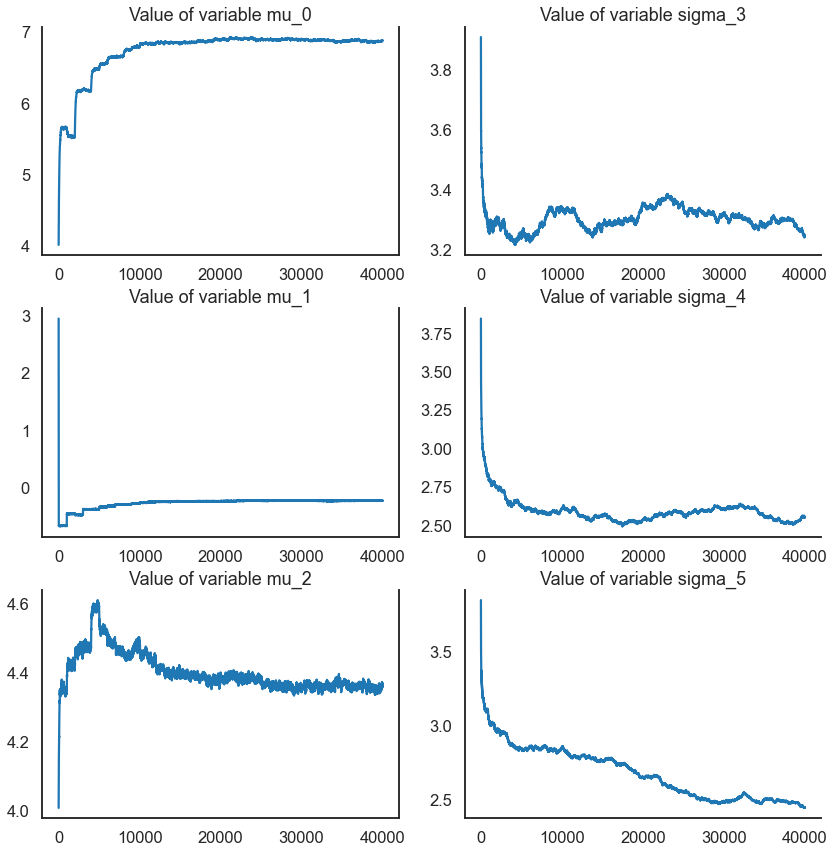

In [29]:
f,ax = plt.subplots(d,2,figsize=(12,12))
f.tight_layout()

for i in np.arange(2*d):
    
    sns.set_style('whitegrid')
    
    if i < d:
        ax[i,0].plot(variables_track[i,:], label='Value')
        ax[i,0].set_title('Value of variable mu_{}'.format(i))
        ax[i,0].spines["top"].set_visible(False)
        ax[i,0].spines["top"].set_visible(False)
    else:
        ax[i-d,1].plot(variables_track[i,:], label='Value')
        ax[i-d,1].set_title('Value of variable sigma_{}'.format(i))
        ax[i-d,1].spines["right"].set_visible(False)
        ax[i-d,1].spines["top"].set_visible(False)

[184908.75465556 183857.86928244 182472.98864922 180698.59448682
 180557.33203967 180263.08109311 180129.16732421 180674.21568259
 180721.66911518 181132.56549135 180393.91697987 179750.63268655
 179136.11159013 179126.8834142  179268.27137188 179302.23697329
 178736.11126512 178537.20682758 178227.6290202  178504.20993941
 178369.88903167 178950.83298729 178680.0724616  178567.84047662
 177867.26441632 177769.56533621 177638.55676386 177541.74056088
 177611.96616151 177568.04222781 177634.42113541 178102.84682928
 177866.97141474 177208.19360059 176735.94083491 176865.91548543
 176443.55288251 176294.09486056 176161.92009012 175971.88800305]


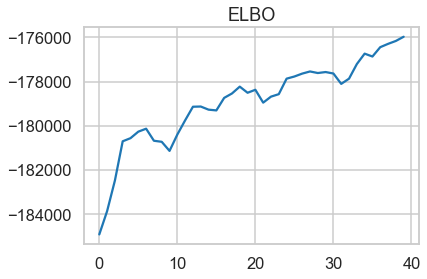

In [30]:
plt.plot(-elbo_track)
plt.title('ELBO')

print(elbo_track)

### Vanilla GD

The cell bellow performs vanilla gradient descent for maximization of the ELBO. 

In [97]:
#Max iterations of coordinate descent and max iterations for every gradient descent within coordinate descent

max_it_gd = 4000
lr=0.000001

#Initialization
variables = 4*np.ones(2*d) 

#Matrices to save values

variables_track = np.zeros((2*d,max_it_gd))

elbo_track = np.zeros(max_it_gd)

for it in np.arange(max_it_gd):

    grad_noise = np.sqrt(0.00001/((it + 1)**(0.55)))*np.random.randn(1)
    
    gradient = full_jacobian(variables)
    
    variables = variables - lr*gradient + grad_noise

    variables_track[:,it] = variables
    elbo_track[it] = elbo(variables) 

    if it%100 ==0:

        print('Iteration ', it, ' completed.')
        print('ELBO value:', elbo_track[it])
        print('Current parameters values:', variables)

Iteration  0  completed.
ELBO value: 3788.0174287198547
Current parameters values: [3.99996803 3.99197909 3.99949955 3.9950107  3.99660436 3.99814651]
Iteration  100  completed.
ELBO value: 3097.7058485734806
Current parameters values: [3.59512354 3.6300408  3.64177856 3.59338977 3.56264975 3.55707091]
Iteration  200  completed.
ELBO value: 2485.9977301417252
Current parameters values: [3.19345096 3.26262235 3.25864061 3.18192337 3.12330668 3.12086864]
Iteration  300  completed.
ELBO value: 1994.6377016368972
Current parameters values: [2.805528   2.91581365 2.9096138  2.78820428 2.71219347 2.72309435]
Iteration  400  completed.
ELBO value: 1544.9453499324088
Current parameters values: [2.41553768 2.55648902 2.53667999 2.38023078 2.29848562 2.31896932]
Iteration  500  completed.
ELBO value: 1179.419001520785
Current parameters values: [2.04358665 2.19845319 2.17063076 1.9916227  1.89680343 1.92477871]
Iteration  600  completed.
ELBO value: 879.7663990331246
Current parameters values: [

/Users/linusbleistein/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()


Iteration  1000  completed.
ELBO value: nan
Current parameters values: [ 0.22700084  0.30583047  0.28530915  0.40432914  0.12739801 -0.60822729]
Iteration  1100  completed.
ELBO value: nan
Current parameters values: [-0.01170518  0.10199674 -0.37419229  0.86050261  0.23532103 -2.29799229]
Iteration  1200  completed.
ELBO value: nan
Current parameters values: [-0.05832842  0.06565728 -1.39196931  0.75899487  0.11355167 -3.41421092]
Iteration  1300  completed.
ELBO value: nan
Current parameters values: [ 0.19955571  0.29522227 -2.49467048 -0.63631237 -1.26205572 -4.47240244]


/Users/linusbleistein/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in exp
/Users/linusbleistein/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp
/Users/linusbleistein/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in multiply
  app.launch_new_instance()
/Users/linusbleistein/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/linusbleistein/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in matmul
/Users/linusbleistein/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/Users/linusbleistein/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: Runtim

Iteration  1400  completed.
ELBO value: nan
Current parameters values: [nan nan nan nan nan nan]
Iteration  1500  completed.
ELBO value: nan
Current parameters values: [nan nan nan nan nan nan]


KeyboardInterrupt: 

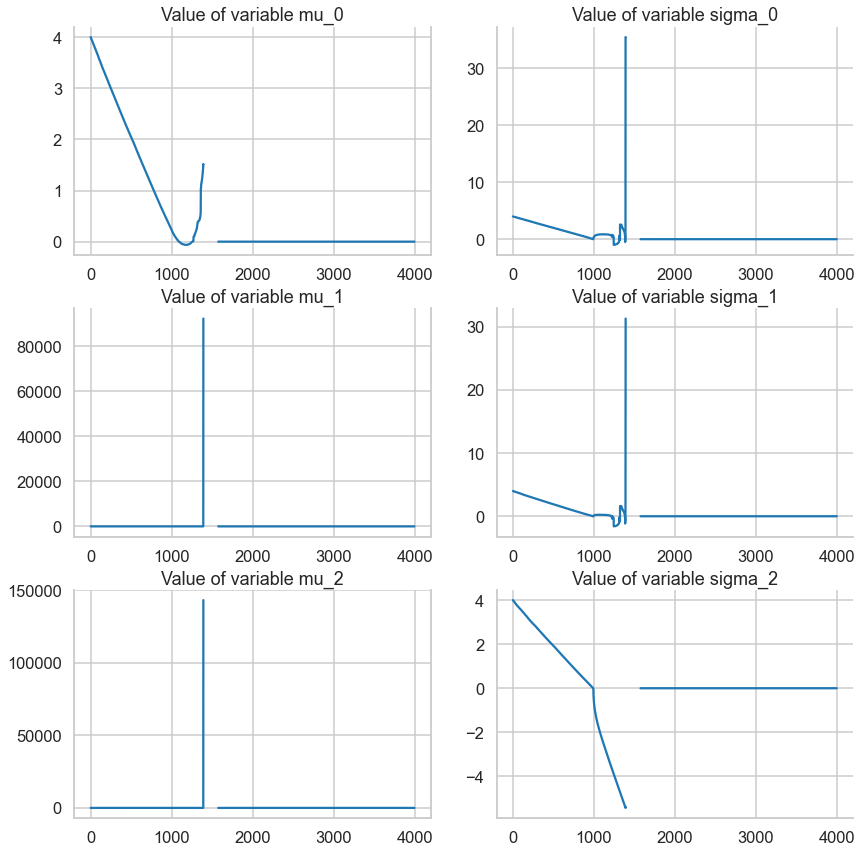

In [98]:
f,ax = plt.subplots(d,2,figsize=(12,12))
f.tight_layout()

for i in np.arange(2*d):
    
    sns.set_style('whitegrid')
    
    if i < d:
        ax[i,0].plot(variables_track[i,:], label='Value')
        ax[i,0].set_title('Value of variable mu_{}'.format(i))
        ax[i,0].spines["top"].set_visible(False)
        ax[i,0].spines["top"].set_visible(False)
    else:
        ax[i-d,1].plot(variables_track[i,:], label='Value')
        ax[i-d,1].set_title('Value of variable sigma_{}'.format(i-3))
        ax[i-d,1].spines["right"].set_visible(False)
        ax[i-d,1].spines["top"].set_visible(False)



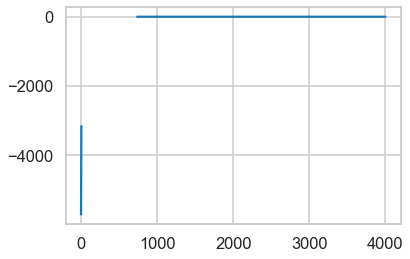

In [84]:
plt.plot(-elbo_track)